## 이미지셋 및 학습된 모델 준비

아래 코드 실행 전 Cifar10.tar.gz 파일과 Team2_model.tar.gz 파일 사전 준비

이미 압축해제한 이미지와 모델 파일이 현 디렉토리에 존재할 경우 준비 과정 skip

In [ ]:
# 중복 생성 방지를 위한 삭제
!rm -rf Cifar10/
!rm -rf Team2_model/

# 데이터셋 다운로드
!tar -xzf Cifar10.tar.gz

# 모델 다운로드
!tar -xzf Team2_model.tar.gz

!ls

cifar10  Cifar10  Cifar10.tar.gz  sample_data  Team2_model.tar.gz


# Evaluation System for Classification of Sifar10 Data Set

In [ ]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# tensorflow와 tf.keras를 임포트한다
import tensorflow as tf
from tensorflow import keras

In [ ]:
# 라이브러리 호출
import glob
import pandas as pd
from skimage.io import imread   # 이미지 불러오기
from skimage.transform import resize   # 이미지 크기 조정
from sklearn.utils import shuffle

from keras.models import Sequential
from keras import layers, models
from keras.layers import Dense, Dropout, BatchNormalization

# confusion matrix의 heatmap를 그리기 위해 seaborn module를 설치하여 import 시켜야한다. 
# seaborn 설치방법(console 창에서 수행): pip install seborn

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


from helper import ModelOptimizer

# class_labels의 사전(dictionary)을 참조하여 이미지의 부류 label를부여할 때 사용하십시요. 반드시  class_labels 사전(dictionary)의 키값의 순서를 따르기 바랍니다.

In [ ]:
class_labels = { 0:'airplane', 1:'automobile',2:'bird', 3:'cat', 4:'deer', 
                5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# 테스트 셋 생성 - test_images, test_labels

In [ ]:
path = './Cifar10/' # 분류별 이미지 폴더가 저장된 위치

In [ ]:
# 상수 사용을 위함
class Default:
    imgR     = 32
    imgC     = 32
    channel  = 3
    imgCount = 6000
    split    = 5000

# Visualize Image
def plot_images(nRow,nCol,img):
    fig = plt.figure()
    fig,ax = plt.subplots(nRow,nCol,figsize=(nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i,j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])

##### Dataset load #####
# get image path from each class
def get_image_path_dict(main_path, class_labels):
    paths_dict = {} # 분류별 이미지 경로를 딕셔너리로 저장
    for label in class_labels:
        paths = glob.glob(main_path + class_labels[label] + '/*.jpg')
        paths_dict[label] = np.array(paths)
    print('Done: get image path dictionary') # for debugging
    return paths_dict

# set x, y data of each class
def set_xy_dict(paths_dict, class_labels):
    x_dict, y_dict = {}, {}
    for label in class_labels:
        x_dict[label] = np.array([imread(paths_dict[label][i])
                                    for i in range(Default.imgCount)])
        x_dict[label] = np.array([resize(x_dict[label][i], 
                                        (Default.imgR, Default.imgC, Default.channel)) 
                                    for i in range(Default.imgCount)])
        y_dict[label] = np.full(Default.imgCount, label)
        print(f'{label}: {x_dict[label].shape} {y_dict[label].shape}')
    print('Done: set x, y dictionary') # for debugging
    return x_dict, y_dict

# split train/test data
def split_dict(x_dict, y_dict, class_labels):
    x_dict_train, x_dict_test = {}, {}
    y_dict_train, y_dict_test = {}, {}
    for label in class_labels:
        x_dict_train[label] = x_dict[label][:Default.split]
        x_dict_test[label]  = x_dict[label][Default.split:]
        y_dict_train[label] = y_dict[label][:Default.split]
        y_dict_test[label]  = y_dict[label][Default.split:]
        print(f'train {label}: {x_dict_train[label].shape} {y_dict_train[label].shape}')
        print(f'test {label}: {x_dict_test[label].shape} {y_dict_test[label].shape}')
    print('Done: split x,y dict --> train/test') # for debugging
    return x_dict_train, x_dict_test, y_dict_train, y_dict_test 

# set x, y data - concatenate
def set_xy(x_dict_train, x_dict_test, 
           y_dict_train, y_dict_test, class_labels):
    x_train = np.concatenate([x_dict_train[label] for label in class_labels])
    x_test  = np.concatenate([x_dict_test[label]  for label in class_labels])
    y_train = np.concatenate([y_dict_train[label] for label in class_labels])
    y_test =  np.concatenate([y_dict_test[label]  for label in class_labels])

    # shuffle x, y
    x_train, y_train = shuffle(x_train, y_train)
    x_test,  y_test  = shuffle(x_test, y_test)
    print('Done: set x, y data') # for debugging
    return (x_train, y_train), (x_test, y_test)

# data load
def data_load(path, class_labels):
    paths_dict = get_image_path_dict(path, class_labels)
    x_dict, y_dict = set_xy_dict(paths_dict, class_labels)
    (x_dict_train, x_dict_test, 
     y_dict_train, y_dict_test) = split_dict(x_dict, y_dict, class_labels)
    (x_train, y_train), (x_test, y_test) = set_xy(x_dict_train, x_dict_test,
                                                  y_dict_train, y_dict_test,
                                                  class_labels)
    print('Successfully load data') # for debugging
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# 데이터셋 로드
(train_images, train_labels), (test_images, test_labels) = data_load(path, class_labels)

print(f'train data: {train_images.shape} {train_labels.shape}')
print(f'test data: {test_images.shape} {test_labels.shape}')

# 팀별로 자제 설계한 인공신경망 모델의 SavedModel 파일들은 반드시 jupyter notebook의 폴더 내에 ''./cifar10/savedModel/'에 위치해야한다.

In [ ]:
model_dir = './cifar10/savedModel/'                               


BATCH_SIZE = 32
PRECISION = 'FP32'

print('Starting', 'Cifar10', model_dir)
model_opt = ModelOptimizer(model_dir)

#save TensorRT engin at my_model_FP32 folder
opt_model = model_opt.convert(model_dir+'_'+PRECISION, precision=PRECISION)

print('Finished!\n')
                                                               

# 성능 비교(수행시간, Confusion Matrix & Accuracy 성능) 
### - 10,000장의 test image는 test_images 배열(10000x32x32x3), test label 목적값은 test_label 배열(10000x1)에 저장되어 있어야 한다.
### - 따라서, 학습시킬 시에 각각 부류 이미지 마다 5001~6000 번호를 갖는 이미지들을 학습에 사용할 수 없으면 성능평가를 위한 test 이미지로 활용된다.
### - 팀별로 최종 프로젝트 프로그램 code를 보고서와 함께 제출해야 하며, 팀별로 설계한 인공신경망 모델과 trainning 이미지를 이용하여 다시 학습시켜 성능을 평가할 계획이다. 
### - 발표 시 후 성능평가와 이후 성능평가 결과가 다를 시에 팀 프로젝트 평가 점수에 불이익을 줄 계획이다. 반드시, 학습 시에 train_images 행렬을 사용하고 성능평가 시에 test_images를 사용하십시오.


## Performance Comparisons: Time

In [ ]:
%%time
test_results = np.argmax(opt_model.predict(test_images), axis=1)

### Performance Comparisons: Confusion Matrix and Accuracy

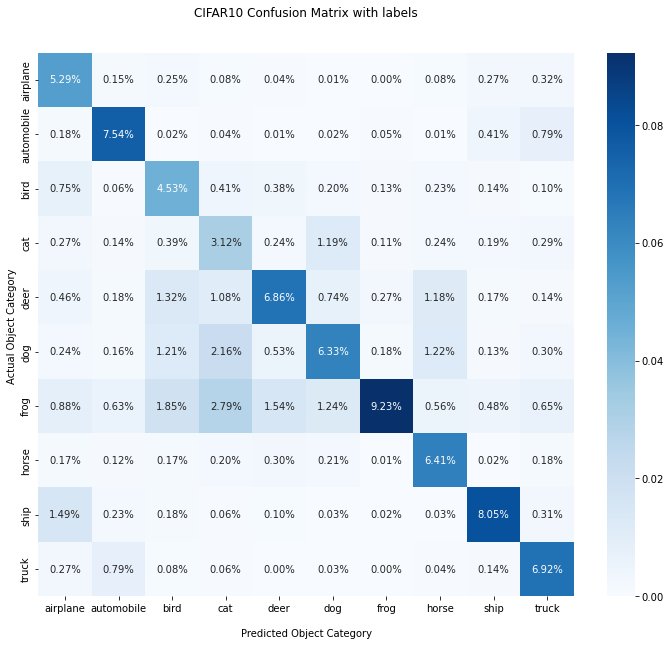


Accuracy: 0.64



In [ ]:
# test_images: test set images, (10000,32,32,3)
# test_labels: test set labels, (10000,)

#test_results=np.argmax(model.predict(test_images),axis=1)
cf_matrix = confusion_matrix(test_results, test_labels)

plt.figure(figsize=(12,10))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%',cmap='Blues')

ax.set_title('CIFAR10 Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Object Category')
ax.set_ylabel('Actual Object Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels.values())
ax.yaxis.set_ticklabels(class_labels.values())

## Display the visualization of the Confusion Matrix.
plt.show()

accuracy = np.trace(cf_matrix)/len(test_labels)
print('\nAccuracy: {:.2f}\n'.format(accuracy))